# Gathering Data: IMDB Movie Rating
This is a notebook of the case study done in this lesson. The aim of this case study is to help us pick a movie to watch based off movie rating websites like Rotten Tomatoes or IMDb. We'll be gathering data of different formats from different sources to help us put together a personalized top 100 lists based off reviews that are trusted. H'enjoy!

## Source: File on Hand 
The first source of data is a flat file given on hand to simulate data gotten from an email or from a thumbdrive or from my company's database. The dataset, [Rotten Tomatoes Top 100 Movies of All Time TSV File](https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ca594d_bestofrt/bestofrt.tsv), was manually downloaded.

In [1]:
import pandas as pd

In [3]:
# importing the rotten tomatoes 'bestofrt.tsv' tsv file into a dataframe
df = pd.read_csv('bestofrt.tsv', sep='\t')

In [4]:
df.head()

,ranking,critic_score,title,number_of_critic_ratings
0,1,99,The Wizard of Oz (1939),110
1,2,100,Citizen Kane (1941),75
2,3,100,The Third Man (1949),77
3,4,99,Get Out (2017),282
4,5,97,Mad Max: Fury Road (2015),370


## Source: Web Scraping
Next, we'll like to get Rotten Tomatoes' audience scores and the number of audience reviews to add to our dataset. Since this isn't easily available, **web scraping** to the rescue!

![webscraping](img/webscrapping.png)

Let's use `BeautifulSoup` to parse the downloaded HTML files of the Rotten Tomatoes webpages for our movies of interest using `lmxl` as our parser.

In [5]:
from bs4 import BeautifulSoup
import os

Let's extract the title, audience score, and the number of audience ratings in each HTML file into a dataframe.

In [50]:
# list of dictionaries to build file by file and later convert to a dataframe
df_list = []
folder = 'rt_html'

# iterating through each html file in the folder
for movie_html in os.listdir(folder):
      with open(os.path.join(folder, movie_html)) as file:
            # making the soup by passing the file into the Beautiful soup
            # constructor together with the parser, lxml
            soup = BeautifulSoup(file, 'lxml')
            title = soup.find('title').contents[0][:-len(' - Rotten Tomatoes')]
            # play with this to be able to re-understand it. 
            audience_score = soup.find('div', class_='audience-score meter').find('span').contents[0][:-1]
            num_audience_ratings = soup.find('div', class_="audience-info hidden-xs superPageFontColor")
            num_audience_ratings = num_audience_ratings.find_all('div')[1].contents[2].strip().replace(',','')
            # append to list of dictionaries
            df_list.append({'title': title,
                            'audience_score': int(audience_score),
                            'number_of_audience_ratings': int(num_audience_ratings)})
audience_score_df = pd.DataFrame(df_list, columns = ['title', 'audience_score', 'number_of_audience_ratings'])      

In [73]:
df

,ranking,critic_score,title,number_of_critic_ratings
0,1,99,The Wizard of Oz (1939),110
1,2,100,Citizen Kane (1941),75
2,3,100,The Third Man (1949),77
3,4,99,Get Out (2017),282
4,5,97,Mad Max: Fury Road (2015),370
...,...,...,...,...
95,96,100,Man on Wire (2008),156
96,97,97,Jaws (1975),74
97,98,100,Toy Story (1995),78
98,99,97,"The Godfather, Part II (1974)",72


Since this course is about Data wrangling - Gathering data, 

* I'll try clean the 'title' column in our `audience_score_df` by replace the non breaking whitespace (`\xa0`) with ' '
* merge the two datasets together
* visualize the relationship between the critical ratings and the audience ratings.

In [105]:
# this is what we want to replace in all the rows of the title column
audience_score_df.title[0]

'12 Angry Men (Twelve Angry Men)\xa0(1957)'

In [106]:
# replacing '\xa0' with ' '
audience_score_df['title'] = audience_score_df['title'].str.split().str.join(' ')

In [107]:
# testing
audience_score_df.title[0]

'12 Angry Men (Twelve Angry Men) (1957)'

Let's merge the two datasets together.

In [110]:
merge_df= pd.merge(df, audience_score_df, on='title')

In [111]:
merge_df

,ranking,critic_score,title,number_of_critic_ratings,audience_score,number_of_audience_ratings
0,1,99,The Wizard of Oz (1939),110,89,874425
1,2,100,Citizen Kane (1941),75,90,157274
2,3,100,The Third Man (1949),77,93,53081
3,4,99,Get Out (2017),282,87,63837
4,5,97,Mad Max: Fury Road (2015),370,86,123937
...,...,...,...,...,...,...
92,96,100,Man on Wire (2008),156,87,29827
93,97,97,Jaws (1975),74,90,942217
94,98,100,Toy Story (1995),78,92,1107731
95,99,97,"The Godfather, Part II (1974)",72,97,409574


In [112]:
merge_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97 entries, 0 to 96
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   ranking                     97 non-null     int64 
 1   critic_score                97 non-null     int64 
 2   title                       97 non-null     object
 3   number_of_critic_ratings    97 non-null     int64 
 4   audience_score              97 non-null     int64 
 5   number_of_audience_ratings  97 non-null     int64 
dtypes: int64(5), object(1)
memory usage: 5.3+ KB


In [157]:
len(merge_df)

97

97?? That means some titles are different in `df` and `audience_score_df`. Let's see which.

In [158]:
# to find the elements in df that aren't in merge_df
list(set(df.title) - set(merge_df.title))

["Army of Shadows (L'Armée des ombres) (1969)",
 'Tokyo Story (Tôkyô monogatari) (1953)',
 'Rashômon (1951)']

In [159]:
# too see the difference between audience_score_df and df
list(set(audience_score_df.title) - set(df.title))

["Army of Shadows (L'ArmÃ©e des ombres) (1969)",
 'RashÃ´mon (1951)',
 'Tokyo Story (TÃ´kyÃ´ monogatari) (1953)']

Let's clean that up.

In [166]:
titleDirty = list(set(audience_score_df.title) - set(df.title))
clean = ["Army of Shadows (L'Armée des ombres) (1969)",
         'Rashômon (1951)',
         'Tokyo Story (Tôkyô monogatari) (1953)']

i=0
for title in titleDirty:
      audience_score_df.title.replace(title, clean[0], inplace=True)
      i+=1

In [167]:
# check
list(set(audience_score_df.title) - set(df.title))

[]

Let's redo our merge

In [168]:
merge_df= pd.merge(df, audience_score_df, on='title')

In [169]:
len(merge_df)

100

Alright, I'm good to go. Now to create the bubble chart and continue with the course.

In [235]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('darkgrid')

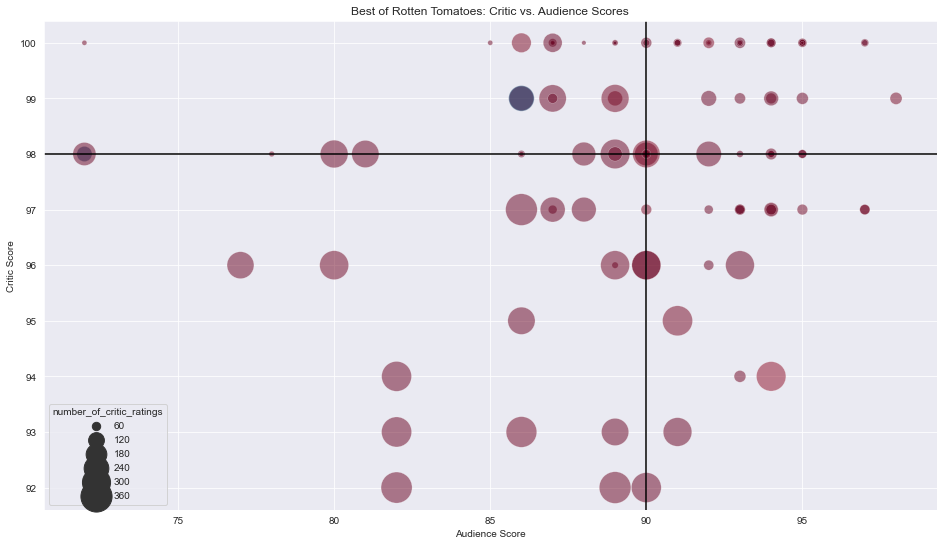

In [257]:
# set seaborn "whitegrid" theme
from turtle import color

# figure size
plt.figure(figsize=(16,9))

# use the scatterplot function
sns.scatterplot(data=merge_df, x="audience_score", y="critic_score", 
                size="number_of_critic_ratings", cmap='RdBu',
                c=merge_df.number_of_audience_ratings,
                edgecolors="black", alpha=0.5, sizes=(10, 1000))

# Add titles (main and on axis)
plt.xlabel("Audience Score")
plt.ylabel("Critic Score")
plt.title("Best of Rotten Tomatoes: Critic vs. Audience Scores")
plt.axvline(x=merge_df.audience_score.median(), color='black')
plt.axhline(y=merge_df.critic_score.median(), color='black')

# show the graph
plt.show()

There's still work to be done on the chart but I'll leave it for now to continue with the course. Below is what I'm trying to achieve.

![bubbleplot](img/visualization.png)

## Source: Downloading File from the Internet.
Here, we'll work a bit with HTTPS and Python's `request` library. We're trying to create a word cloud visualization for the Top 100 movies based of Dr Ebert's reviews so as to see what made the movie stand out. 

Unfortunately, we could only find 88 movie reviews off his site so we'll work with that number.

In [258]:
import requests
import os

In [259]:
# make directory if it doesn't already exist
folder_name = 'ebert_reviews'

if not os.path.exists(folder_name):
      os.makedirs(folder_name)

In [260]:
ebert_review_urls = ['https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad9900_1-the-wizard-of-oz-1939-film/1-the-wizard-of-oz-1939-film.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad9901_2-citizen-kane/2-citizen-kane.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad9901_3-the-third-man/3-the-third-man.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad9902_4-get-out-film/4-get-out-film.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad9902_5-mad-max-fury-road/5-mad-max-fury-road.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad9902_6-the-cabinet-of-dr.-caligari/6-the-cabinet-of-dr.-caligari.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad9903_7-all-about-eve/7-all-about-eve.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad9903_8-inside-out-2015-film/8-inside-out-2015-film.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad9903_9-the-godfather/9-the-godfather.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad9904_10-metropolis-1927-film/10-metropolis-1927-film.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad9904_11-e.t.-the-extra-terrestrial/11-e.t.-the-extra-terrestrial.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad9904_12-modern-times-film/12-modern-times-film.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad9904_14-singin-in-the-rain/14-singin-in-the-rain.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad9905_15-boyhood-film/15-boyhood-film.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad9905_16-casablanca-film/16-casablanca-film.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad9905_17-moonlight-2016-film/17-moonlight-2016-film.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad9906_18-psycho-1960-film/18-psycho-1960-film.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad9906_19-laura-1944-film/19-laura-1944-film.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad9906_20-nosferatu/20-nosferatu.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad9907_21-snow-white-and-the-seven-dwarfs-1937-film/21-snow-white-and-the-seven-dwarfs-1937-film.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad9907_22-a-hard-day27s-night-film/22-a-hard-day27s-night-film.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad9907_23-la-grande-illusion/23-la-grande-illusion.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad9908_25-the-battle-of-algiers/25-the-battle-of-algiers.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad9908_26-dunkirk-2017-film/26-dunkirk-2017-film.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad9908_27-the-maltese-falcon-1941-film/27-the-maltese-falcon-1941-film.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad9909_29-12-years-a-slave-film/29-12-years-a-slave-film.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad9909_30-gravity-2013-film/30-gravity-2013-film.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad9909_31-sunset-boulevard-film/31-sunset-boulevard-film.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad990a_32-king-kong-1933-film/32-king-kong-1933-film.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad990a_33-spotlight-film/33-spotlight-film.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad990a_34-the-adventures-of-robin-hood/34-the-adventures-of-robin-hood.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad990b_35-rashomon/35-rashomon.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad990b_36-rear-window/36-rear-window.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad990b_37-selma-film/37-selma-film.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad990c_38-taxi-driver/38-taxi-driver.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad990c_39-toy-story-3/39-toy-story-3.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad990c_40-argo-2012-film/40-argo-2012-film.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad990d_41-toy-story-2/41-toy-story-2.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad990d_42-the-big-sick/42-the-big-sick.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad990d_43-bride-of-frankenstein/43-bride-of-frankenstein.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad990d_44-zootopia/44-zootopia.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad990e_45-m-1931-film/45-m-1931-film.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad990e_46-wonder-woman-2017-film/46-wonder-woman-2017-film.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad990e_48-alien-film/48-alien-film.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad990f_49-bicycle-thieves/49-bicycle-thieves.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad990f_50-seven-samurai/50-seven-samurai.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad990f_51-the-treasure-of-the-sierra-madre-film/51-the-treasure-of-the-sierra-madre-film.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad9910_52-up-2009-film/52-up-2009-film.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad9910_53-12-angry-men-1957-film/53-12-angry-men-1957-film.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad9910_54-the-400-blows/54-the-400-blows.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad9911_55-logan-film/55-logan-film.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad9911_57-army-of-shadows/57-army-of-shadows.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad9912_58-arrival-film/58-arrival-film.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad9912_59-baby-driver/59-baby-driver.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad9913_60-a-streetcar-named-desire-1951-film/60-a-streetcar-named-desire-1951-film.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad9913_61-the-night-of-the-hunter-film/61-the-night-of-the-hunter-film.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad9913_62-star-wars-the-force-awakens/62-star-wars-the-force-awakens.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad9913_63-manchester-by-the-sea-film/63-manchester-by-the-sea-film.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad9914_64-dr.-strangelove/64-dr.-strangelove.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad9914_66-vertigo-film/66-vertigo-film.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad9914_67-the-dark-knight-film/67-the-dark-knight-film.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad9915_68-touch-of-evil/68-touch-of-evil.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad9915_69-the-babadook/69-the-babadook.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad9915_72-rosemary27s-baby-film/72-rosemary27s-baby-film.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad9916_73-finding-nemo/73-finding-nemo.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad9916_74-brooklyn-film/74-brooklyn-film.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad9917_75-the-wrestler-2008-film/75-the-wrestler-2008-film.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad9917_77-l.a.-confidential-film/77-l.a.-confidential-film.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad9918_78-gone-with-the-wind-film/78-gone-with-the-wind-film.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad9918_79-the-good-the-bad-and-the-ugly/79-the-good-the-bad-and-the-ugly.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad9918_80-skyfall/80-skyfall.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad9919_82-tokyo-story/82-tokyo-story.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad9919_83-hell-or-high-water-film/83-hell-or-high-water-film.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad9919_84-pinocchio-1940-film/84-pinocchio-1940-film.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad9919_85-the-jungle-book-2016-film/85-the-jungle-book-2016-film.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad991a_86-la-la-land-film/86-la-la-land-film.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad991b_87-star-trek-film/87-star-trek-film.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad991b_89-apocalypse-now/89-apocalypse-now.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad991c_90-on-the-waterfront/90-on-the-waterfront.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad991c_91-the-wages-of-fear/91-the-wages-of-fear.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad991c_92-the-last-picture-show/92-the-last-picture-show.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad991d_93-harry-potter-and-the-deathly-hallows-part-2/93-harry-potter-and-the-deathly-hallows-part-2.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad991d_94-the-grapes-of-wrath-film/94-the-grapes-of-wrath-film.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad991d_96-man-on-wire/96-man-on-wire.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad991e_97-jaws-film/97-jaws-film.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad991e_98-toy-story/98-toy-story.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad991e_99-the-godfather-part-ii/99-the-godfather-part-ii.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad991e_100-battleship-potemkin/100-battleship-potemkin.txt']

In [261]:
for url in ebert_review_urls:
      # creating the request
      response = requests.get(url)
      
      # accessing content and writing to a file
      with open(os.path.join(folder_name, url.split('/')[-1]), mode='wb') as file:
            file.write(response.content)

In [262]:
# confirming if our code worked.
assert len(ebert_review_urls) == len(os.listdir(folder_name))

Let's read the txt files into memory using `glob` and make a dataframe.

In [264]:
# import glob
import glob

In [297]:
# list of dictionaries to build file by file and later convert to df
reviews_list = []

# iterate through .txt files in 'ebert_reviews' folder
for ebert_review in glob.glob('ebert_reviews/*.txt'):  # * is a wildcard
      # encoding can be gotten by meta charset attribute of the HTML file
      with open(ebert_review, encoding='utf-8') as file:
            # let's get title, url and text
            title = file.readline()[:-1]
            review_url = file.readline()[:-1]
            review_text = file.read()
            #print(review_text); logging
            #break
            
            # append to list of dictionaries
            reviews_list.append({'title': title,
                                 'review_url': review_url,
                                 'review_text': review_text})

ebertReview_df = pd.DataFrame(reviews_list)            

In [299]:
ebertReview_df.head()

,title,review_url,review_text
0,The Wizard of Oz (1939),http://www.rogerebert.com/reviews/great-movie-...,As a child I simply did not notice whether a m...
1,Metropolis (1927),http://www.rogerebert.com/reviews/great-movie-...,The opening shots of the restored “Metropolis”...
2,Battleship Potemkin (1925),http://www.rogerebert.com/reviews/great-movie-...,"""The Battleship Potemkin” has been so famous f..."
3,E.T. The Extra-Terrestrial (1982),http://www.rogerebert.com/reviews/great-movie-...,Dear Raven and Emil:\n\nSunday we sat on the b...
4,Modern Times (1936),http://www.rogerebert.com/reviews/modern-times...,"A lot of movies are said to be timeless, but s..."
